In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint

### monte carlo simulation

In [4]:
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.proportion import proportion_confint
from statsmodels.regression.linear_model import OLS

# monte carlo simulation
a_orig = a_orig_values[5]
delta = 0.05

mc_samples = [10**k for k in range(1, 6)]
mc_errors = []
for N in mc_samples:
    samples = 1.0*(np.random.rand(N) <= a_orig)
    ci = proportion_confint(sum(samples), N, alpha=delta, method='beta')
    mc_errors += [(ci[1]-ci[0])/2]
    
x_range = 17
model = OLS(np.log10(mc_errors),sm.add_constant(np.log10(mc_samples)))
results = model.fit()
mc_x_reg = np.array([a for a in range(1,x_range)])
mc_y_reg = results.predict(sm.add_constant(mc_x_reg))

mc_samples = 10**(mc_x_reg)
mc_errors = 10**(mc_y_reg)

### load qaes, mlae and cqae data

In [5]:
# MLAE
# [m, a_orig, delta, N]
mlae_results = np.load('results_mlae_100_new_2.npy', allow_pickle=True).flatten()[0]

# QAES
# [a_orig, delta, epsilon]
qaes_results = np.load('results_counting_simplified.npy', allow_pickle=True).flatten()[0]

In [6]:
# CQAE with N_shots = 100
cqae100 = np.loadtxt('ae100.csv')
# CQAE with N_shots = 1000
cqae1000 = np.loadtxt('ae1000.csv')

#for comparison, we choose N_shots = 100
cqae_errors = cqae100[1]
cqae_samples = cqae100[0]

##### ranges and variables

In [3]:
# same values for all
a_orig_values = [0.01] + list(np.linspace(0.1, 0.9, 9)) + [0.99]
delta_values = np.linspace(0.01, 0.1, 10) 
delta_values_mlae = [0.01*i for i in range(1,11)]

# mlae values
m_values = range(1, 25)
N_values = [10, 100, 1000, 10000]

# qaes values
eps_values = [10**(-k) for k in range(1, 9)]

### iqae simulation

In [7]:
def sample_iqae(k, theta, num_samples):
    """
    samples from Q^k A|0> for theta normalized to [0, 1]!
    """
    p = np.sin(2*np.pi*theta*(2*k+1))**2
    samples = 1.0*(np.random.rand(num_samples) <= p)
    return samples

def cp_halfconfint(N_total_plus,N_total_shots,alpha,T):
    p_min, p_max = proportion_confint(N_total_plus, N_total_shots, method='beta', alpha=alpha/T)
    return np.abs(np.arccos(1-2*p_max)-np.arccos(1-2*p_min))/2

def critical_CP_N_shots(eps, alpha):
    T = int(np.log2(np.pi/8/eps))+1
    def g_CP_param(x):
        est = (lambda N,t: cp_estimate(int(t*N),N,alpha,T)-8*np.pi/21)(x[0],x[1])
        err = (lambda N,t: cp_halfconfint(int(t*N),N,alpha,T)-np.pi/21)(x[0],x[1])
        return np.array([est, err])
    
    res=root(constrainedFunction, x0=np.asarray([300,0.2]),
             args=(g_CP_param, np.asarray([10, 0.]), np.asarray([1000, 1.])), method='hybr',tol=0.000001)
    return res.x[0]

def calc_CP_L_range(eps, alpha, N_shots):
    x = np.linspace(0, np.pi, 10000)
    T = int(np.log2(np.pi/8/eps))+1
    g_CP_t_domain = [(x >= 0) & (x <= 1.+1/10/N_shots)]
    g_CP_y = [(lambda t: cp_halfconfint(int(t*N_shots),N_shots,0.05,T))(t) for t in x[tuple(g_CP_t_domain)]]
    return [np.min(g_CP_y),np.max(g_CP_y)]

def find_next_k_old(K_i, up_i, theta_l, theta_u, r):
    # find feasible K = 4k+2
    K_max = int(1/(2*(theta_u-theta_l)))
    K = K_max - (K_max-2)%4
    #print(K,K_max,K_i)
    while K >= r*K_i:
        theta_min = K*theta_l - int(K*theta_l)
        theta_max = K*theta_u - int(K*theta_u)
        #print(K_i, K_max, K, theta_u, theta_l, int(K*theta_u),int(K*theta_l), theta_max, theta_min)
        if  theta_max <= 1/2 and theta_min <= 1/2 and int(K*theta_u) == int(K*theta_l):
            up = True
            return (K, up)
        elif theta_max >= 1/2 and theta_min >= 1/2 and int(K*theta_u) == int(K*theta_l):
            up = False
            return (K, up)
        K = K - 4
    return (K_i, up_i)

def find_next_k(K_i, up_i, theta_l, theta_u, r, epsilon, L_max):
    # find feasible K = 4k+2
    K_ub = int(L_max/epsilon)+1
    if (K_ub >= K_i):
        K_max = int(1/(2*(theta_u-theta_l)))
        r_tld = r
    else:
        K_max = K_i
        r_tld = 1
    K = K_max - (K_max-2)%4
    
    #print(K, K_i, int(L_max/epsilon)+1)
    
    while K >= r_tld*K_i:
        theta_min = K*theta_l - int(K*theta_l)
        theta_max = K*theta_u - int(K*theta_u)
        #print(K_i, K_max, K, theta_u, theta_l, int(K*theta_u),int(K*theta_l), theta_max, theta_min)
        if  theta_max <= 1/2 and theta_min <= 1/2 and int(K*theta_u) == int(K*theta_l):
            up = True
            return (K, up)
        elif theta_max >= 1/2 and theta_min >= 1/2 and int(K*theta_u) == int(K*theta_l):
            up = False
            return (K, up)
        K = K - 4
    return (K_i, up_i)

def iqae(epsilon, alpha, a_orig, N_shots=100, method='chernoff', r = 2, old = True):
    
    # compute and normalize theta
    theta_orig = np.arcsin(np.sqrt(a_orig))
    theta = theta_orig / 2 / np.pi
    
    #intilialize all parameters
    K = [2]  # = 4k+2 for k=0
    theta_u = [1/4-theta_orig*0.000000000001]
    theta_l = [0+theta_orig*0.000000000001]
    p_min = [0]
    p_max = [1]
    eps_tilde = np.abs(theta_u[-1]-theta_l[-1])
    up = [True]
    samples_history = []
    n_shots_history = []
    i=0
    
    # translate target epsilon into 'full-width'-epsilon for theta
    eps = epsilon / np.pi
    T = int(np.log(1/eps)/np.log(2))+1
    N_total_shots = N_shots
    num_oracle_queries = 0
    
    if method != 'chernoff':
        L_max = calc_CP_L_range(epsilon, alpha, N_total_shots)[1]/2/np.pi
        L_min = calc_CP_L_range(epsilon, alpha, N_total_shots)[0]/2/np.pi
    else:
        L_max = np.arcsin((2/(N_total_shots)*np.log(2*T/alpha))**(1/4))/2/np.pi
        L_min = np.arcsin(np.sin(L_max)**2)
        
    N_shots_i = N_shots
    #print(L_min, L_max, L_max/L_min)
    
    while eps_tilde > eps:
        
        i = i + 1
        
        if not old:
            K_i, up_i = find_next_k(K[-1], up[-1], theta_l[-1], theta_u[-1], \
                                        r = r, epsilon = eps, L_max = L_max)
        else:
            K_i, up_i = find_next_k_old(K[-1], up[-1], theta_l[-1], theta_u[-1], \
                                        r = r)
        K.append(K_i)
        up.append(up_i)
        k_i = (K_i - 2)/4
        
        if K_i > int(L_max/eps):
            #N_shots_i = int(N_shots*(np.sin(L_max)/np.sin(eps*K_i))**4)
            N_shots_i = int((L_max/eps)*N_shots/K_i/10)
            if N_shots_i == 0:
                N_shots_i = 1
            #N_shots_i = int(N_shots/20)
        else:
            N_shots_i = N_shots
        
        # sample from Q^k A |0> --> sin^2((2k+1)theta_a)
        samples = sample_iqae(k_i, theta, N_shots_i)    
        samples_history.append(samples)
        n_shots_history.append(N_shots_i)
        
        # track number of A oracle calls
        num_oracle_queries += N_shots_i * k_i
        
        #if on previous iterations we have K_{i-1}==K_i, then we need to sum up these samples
        l=1
        if i>1:
            while K[i-l]==K[i] and i>=l+1:
                l=l+1
            sum_total_samples = sum([sum(samples_history[j]) for j in range(i-l,i)])
            N_total_shots = sum([n_shots_history[j] for j in range(i-l,i)])
            
            #print(l, N_total_shots, sum_total_samples)
        else:
            sum_total_samples = sum(samples)
            N_total_shots = N_shots_i

        p = sum_total_samples/N_total_shots
        
        if method != 'chernoff':
            p_min_i, p_max_i = proportion_confint(sum_total_samples, N_total_shots, method=method, alpha=alpha/T) 
        else:
            delta_p = np.sqrt(np.log(2*T/alpha)/2/N_total_shots)
            p_min_i = max(0, p - delta_p)
            p_max_i = min(1, p + delta_p)
                
        p_min.append(p_min_i)
        p_max.append(p_max_i)
        
        if up_i:
            theta_min_i = np.arccos(1-2*p_min_i)/2/np.pi
            theta_max_i = np.arccos(1-2*p_max_i)/2/np.pi
        else:
            theta_min_i = 1-np.arccos(1-2*p_max_i)/2/np.pi
            theta_max_i = 1-np.arccos(1-2*p_min_i)/2/np.pi
            
        whole = min(int(K_i*theta_u[-1]),int(K_i*theta_l[-1]))
        
        #print(theta_l[-1]*K_i-int(theta_l[-1]*K_i), theta_u[-1]*K_i-int(theta_u[-1]*K_i), 1-np.abs(theta_u[-1]-theta_l[-1])*K_i*2)
        #print(theta_min_i, theta_max_i, K_i)
        #print("\n")
            
        theta_u_i = (whole+theta_max_i)/K_i
        theta_l_i = (whole+theta_min_i)/K_i
        
        theta_u.append(theta_u_i)
        theta_l.append(theta_l_i)

        eps_tilde = np.abs(theta_u[-1]-theta_l[-1])
        #print(K_i,up_i,eps_tilde,int(K_i*theta_u[-1]),int(K_i*theta_l[-1]))
        
    q = [K[j]/K[j-1] for j in range(1,i+1)]
    
    a_l = np.sin(2*np.pi*theta_l[-1])**2
    a_u = np.sin(2*np.pi*theta_u[-1])**2
    results = { 
        'theta_u': theta_u,
        'theta_l': theta_l,
        'a_l': a_l,
        'a_u': a_u,
        'epsilon': (a_u-a_l)/2,
        'p_max': p_max,
        'p_min': p_min,
        'up': up,
        'schedule_K': K,
        'q': q,
        'num_oracle_queries': num_oracle_queries,
        'samples': [len(a) for a in samples_history]
    }

    return results

In [8]:
eps = 10**(-3)
result = iqae(eps, 0.05, 0.3, N_shots=100, method='chernoff', r = 2, old = True)
print(eps/result['epsilon'],result['num_oracle_queries'])
print(result['schedule_K'],result['samples'])
print(result['q'])

result = iqae(eps, 0.05, 0.3, N_shots=100, method='chernoff', r = 2, old = False)
print(eps/result['epsilon'],result['num_oracle_queries'])
print(result['schedule_K'],result['samples'])
print(result['q'])

print("\n")

result_beta = iqae(eps, 0.05, 0.3, N_shots=100, method='beta', r = 2, old = True)
print(eps/result_beta['epsilon'],result_beta['num_oracle_queries'])
print(result_beta['schedule_K'],result_beta['samples'])
print(result_beta['q'])

result_beta = iqae(eps, 0.05, 0.3, N_shots=100, method='beta', r = 2, old = False)
print(eps/result_beta['epsilon'],result_beta['num_oracle_queries'])
print(result_beta['schedule_K'],result_beta['samples'])
print(result_beta['q'])

1.1431813554588068 11348.0
[2, 2, 2, 2, 2, 14, 34, 74, 230, 918, 918, 918, 918] [100, 100, 100, 100, 100, 100, 100, 100, 3, 3, 3, 3]
[1.0, 1.0, 1.0, 1.0, 7.0, 2.4285714285714284, 2.176470588235294, 3.108108108108108, 3.991304347826087, 1.0, 1.0, 1.0]
1.1581886386493387 13940.0
[2, 2, 2, 2, 6, 18, 46, 170, 594, 594, 594, 594, 594, 594, 594, 594, 594, 594, 594] [100, 100, 100, 100, 100, 100, 100, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
[1.0, 1.0, 1.0, 3.0, 3.0, 2.5555555555555554, 3.6956521739130435, 3.4941176470588236, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


1.096119953098546 6644.0
[2, 2, 2, 2, 14, 50, 242, 242, 242, 242, 486, 486, 486, 486, 486, 486, 486, 486, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006] [100, 100, 100, 100, 100, 5, 5, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1]
[1.0, 1.0, 1.0, 7.0, 3.5714285714285716, 4.84, 1.0, 1.0, 1.0, 2.0082644628099175, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0699588477366255, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
1.101834688603719 1

### collect and plot results

In [9]:
delta = delta_values[4]
delta_mlae = delta_values_mlae[4]
a_orig = a_orig_values[5]
N = N_values[1]

In [10]:
iqae_errors_target = [10**(-i) for i in range(1,9)]
iqae_errors_ch = []
iqae_samples_ch = []
iqae_errors_cp = []
iqae_samples_cp = []

# collect IQAE results
for eps in iqae_errors_target:
    result = iqae(eps, delta, a_orig, N_shots=N, method='chernoff', r = 2, old = True)
    iqae_errors_ch += [result['epsilon']]
    iqae_samples_ch += [result['num_oracle_queries']]
    
    result = iqae(eps, delta, a_orig, N_shots=N, method='beta', r = 2, old = True)
    iqae_errors_cp += [result['epsilon']]
    iqae_samples_cp += [result['num_oracle_queries']]

In [11]:
mlae_errors = []
mlae_samples = []

qaes_errors = []
qaes_samples = []

# collect MLAE results
for m in m_values[1:23]:
    results = mlae_results[(m, a_orig, delta_mlae, N)]
    mlae_errors += [results['epsilon']]
    mlae_samples += [results['num_oracle_calls']]

# collect QAES results
for eps in eps_values:
    results = qaes_results[(a_orig, delta, eps)]
    qaes_errors += [eps]
    qaes_samples += [results['num_oracle_queries']]

delta  = 0.05000000000000001
a_orig = 0.5
N      = 100


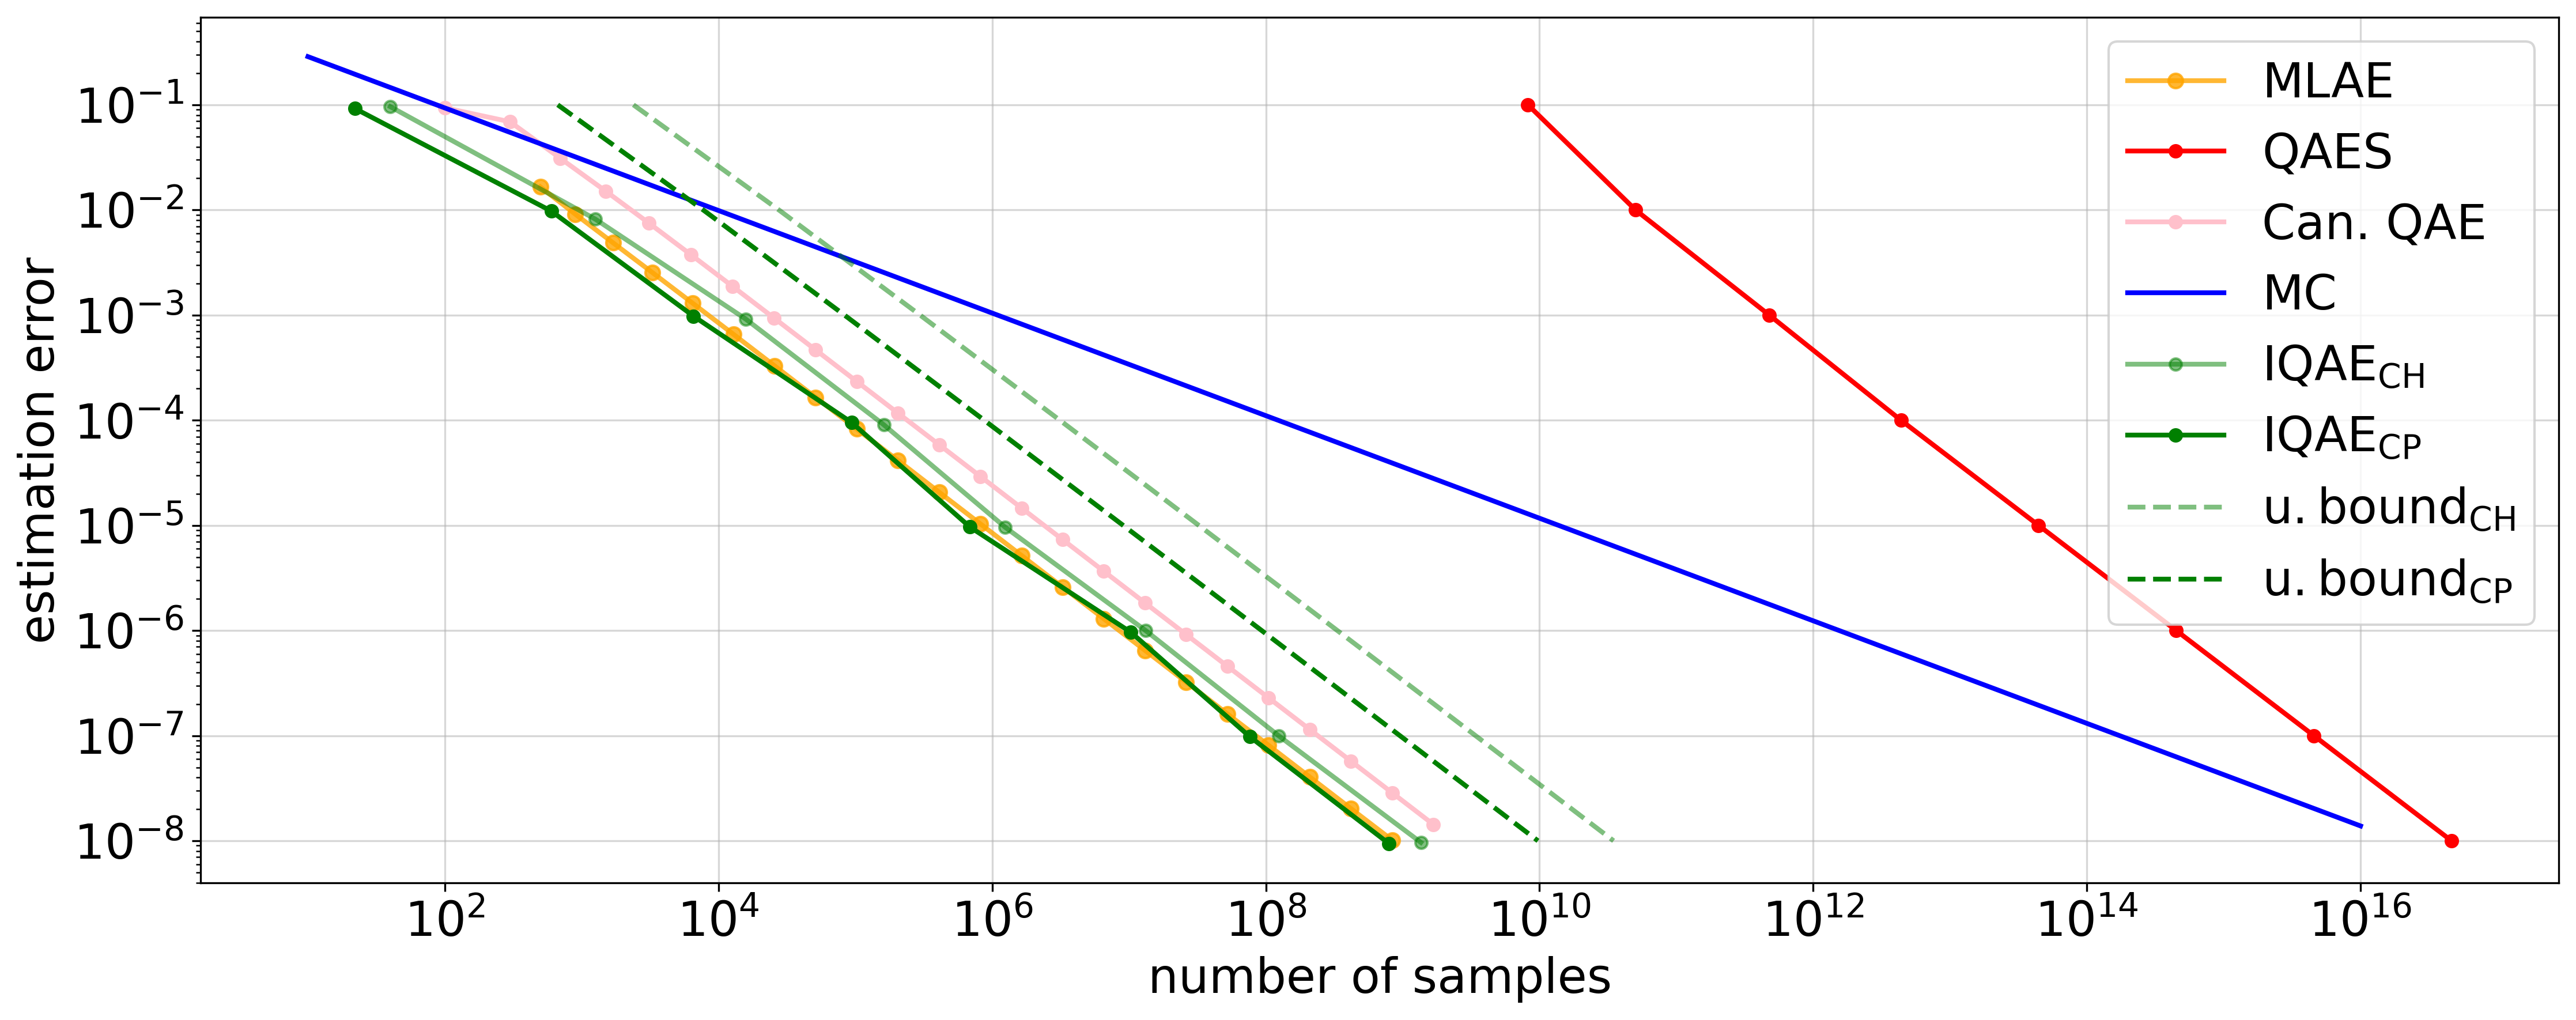

In [12]:
print('delta  = %s' % delta)
print('a_orig = %s' % a_orig)
print('N      = %s' % N)

ch_bound = [50/eps*np.log(2/delta*np.log2(np.pi/4/eps)) for eps in iqae_errors_target]
cp_bound = [14/eps*np.log(2/delta*np.log2(np.pi/4/eps)) for eps in iqae_errors_target]

fontsize = 20
linewidth = 2
markersize = 10
plt.figure(figsize=(15, 6), dpi=300)
plt.loglog(mlae_samples, mlae_errors, '.-',color='orange', alpha=0.8, label='MLAE', linewidth=linewidth, markersize=1.2*markersize)
plt.loglog(qaes_samples, qaes_errors, '.-',color='red', label='QAES', linewidth=linewidth, markersize=markersize)
plt.loglog(cqae_samples, cqae_errors, '.-',color='pink', label='Can. QAE', linewidth=linewidth, markersize=markersize)
plt.loglog(mc_samples, mc_errors, '-', color='blue', label='MC', linewidth=linewidth, markersize=markersize)
plt.loglog(iqae_samples_ch, iqae_errors_ch, '.-',color='green', alpha=0.5, label='$\mathrm{IQAE_{CH}}$', linewidth=linewidth, markersize=markersize)
plt.loglog(iqae_samples_cp, iqae_errors_cp, '.-',color='g', label='$\mathrm{IQAE_{CP}}$', linewidth=linewidth, markersize=markersize)
plt.loglog(ch_bound, iqae_errors_target, '--', color='green',alpha=0.5, label='$\mathrm{u.bound_{CH}}$', linewidth=linewidth, markersize=markersize)
plt.loglog(cp_bound, iqae_errors_target, '--', color='g' ,label='$\mathrm{u.bound_{CP}}$', linewidth=linewidth, markersize=markersize)
plt.legend(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('number of samples', fontsize=fontsize)
plt.ylabel('estimation error', fontsize=fontsize)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('qae_comparison_with_can.pdf')
plt.show()

### Compare IQAE_CP and CQAE

In [113]:
#construct linear regression models
x_range = np.arange(0,-10,-1)

model_c = OLS(np.log10(cqae_samples),sm.add_constant(np.log10(cqae_errors)))
results_c = model_c.fit()
y_reg_c = results_c.predict(sm.add_constant(x_range))

model_cp = OLS(np.log10(iqae_samples_cp),sm.add_constant(np.log10(iqae_errors_cp)))
results_cp = model_cp.fit()
y_reg_cp = results_cp.predict(sm.add_constant(x_range))

model_ch = OLS(np.log10(iqae_samples_ch),sm.add_constant(np.log10(iqae_errors_ch)))
results_ch = model_ch.fit()
y_reg_ch = results_ch.predict(sm.add_constant(x_range))

In [125]:
#print corresponding range of errors
print('error:',1/10**(-x_range),'\n')
#number of samples for CQAE
print("canonical qae:",10**y_reg_c,'\n')
##number of samples for IQAE_CP
print("iqae_cp:",10**y_reg_cp,'\n')
##number of samples for IQAE_CH
print("iqae_ch:",10**y_reg_ch,'\n')

error: [1.e+00 1.e-01 1.e-02 1.e-03 1.e-04 1.e-05 1.e-06 1.e-07 1.e-08 1.e-09] 

canonical qae: [1.90367961e+01 1.98187220e+02 2.06327650e+03 2.14802445e+04
 2.23625336e+05 2.32810624e+06 2.42373191e+07 2.52328536e+08
 2.62692791e+09 2.73482753e+10] 

iqae_cp: [3.21933916e+00 3.72530926e+01 4.31080056e+02 4.98831108e+03
 5.77230311e+04 6.67951189e+05 7.72930288e+06 8.94408514e+07
 1.03497897e+09 1.19764229e+10] 

iqae_ch: [5.56982324e+00 6.58391739e+01 7.78264701e+02 9.19962856e+03
 1.08745990e+05 1.28545303e+06 1.51949464e+07 1.79614806e+08
 2.12317158e+09 2.50973607e+10] 



In [117]:
#average_advantage for IQAE_CP
print('advantage for cp: ',np.mean(10**y_reg_c/10**y_reg_cp))

#average_advantage for IQAE_CH
print('advantage for ch: ',np.mean(10**y_reg_c/10**y_reg_ch))

advantage for cp:  3.8463850558886157
advantage for ch:  2.060843878827691


### iqae_ch coeffcient analysis

In [25]:
epsilons = [10**(-i) for i in range(1,7)]
alphas = [0.1,0.05,0.01]
a_values_100 = [i/100 for i in range(101)]
a_values_10 = [i/10 for i in range(11)]

In [26]:
a_orig = 0.5
N = 100
iqae_ch = {}

for epsilon in epsilons:
    for alpha in alphas:
        iqae_ch[(epsilon,alpha)] = []
        for a in a_values_100:
            result = iqae(epsilon, alpha, a, N_shots=N, method='chernoff', r = 2, old = True)
            iqae_ch[(epsilon,alpha)] += [np.array([result['num_oracle_queries'],result['epsilon']])]

In [27]:
factors_ch = {}
for alpha in alphas:
    for epsilon in epsilons:
        N_orac = np.array(iqae_ch[(epsilon,alpha)]).T[0]
        eps = np.array(iqae_ch[(epsilon,alpha)]).T[1]
        log_coef = np.log(2/alpha*np.log2(np.pi/4/eps))
        factors_ch[(alpha, epsilon)] = N_orac*eps/log_coef

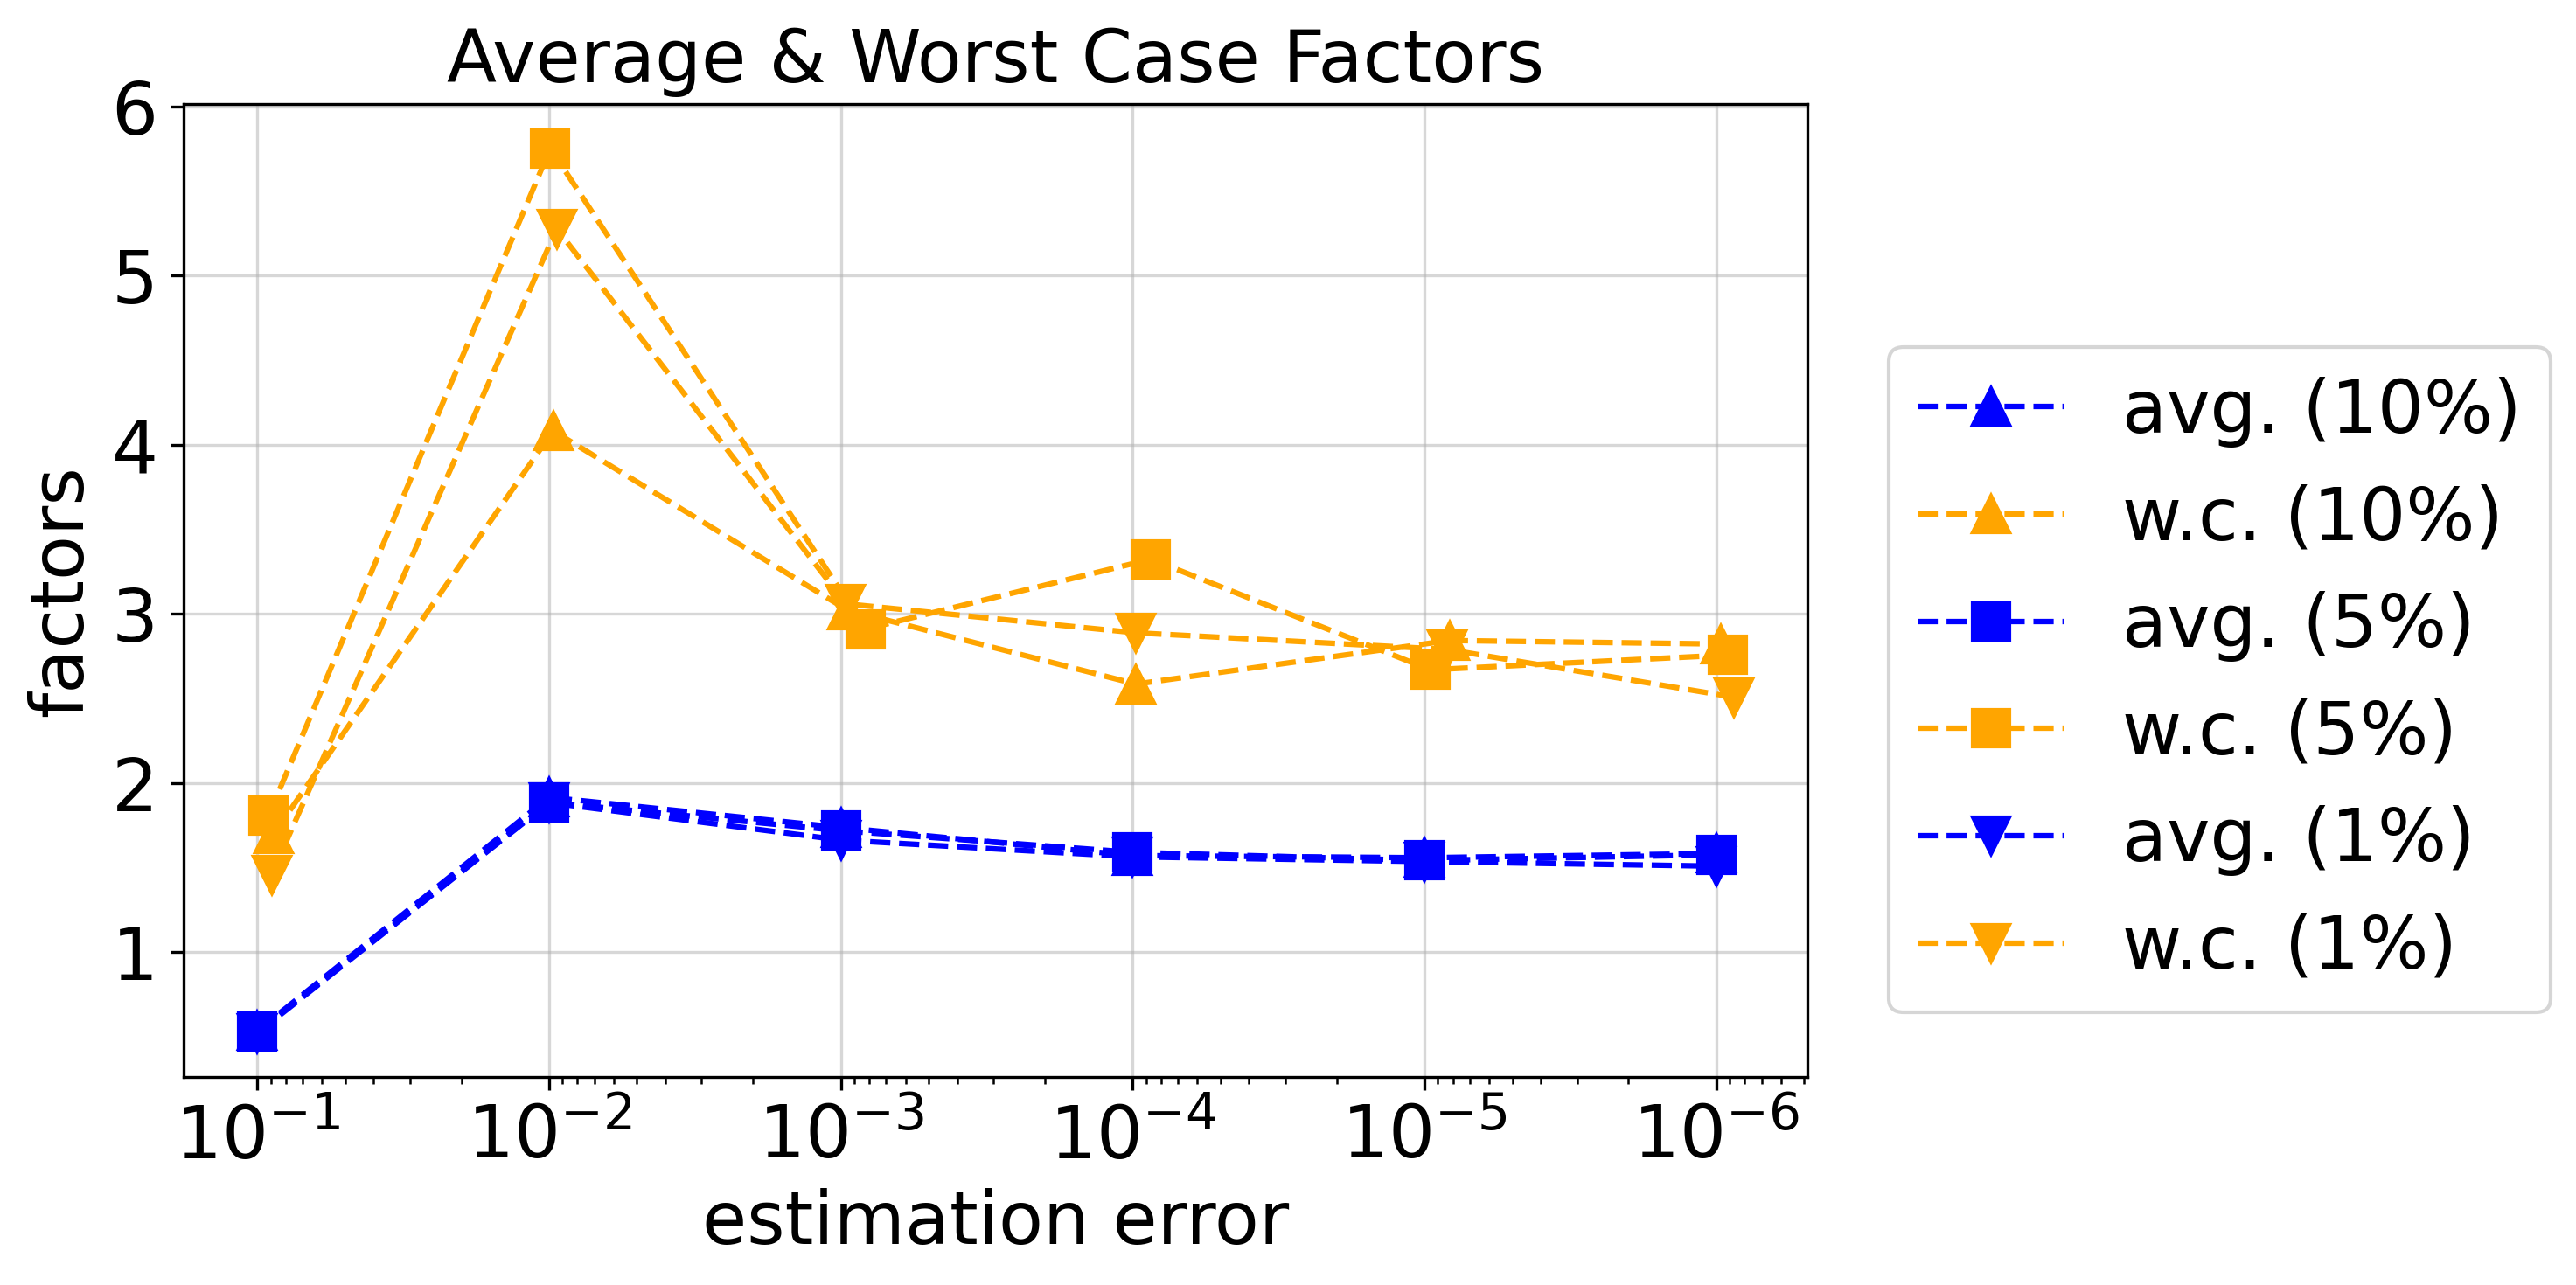

In [28]:
fontsize = 20
linewidth = 1.5
markersize = 10
plt.figure(figsize=(10, 5), dpi=300)
markers = { 0.1 : '^--',
    0.05 : 's--',
    0.01 : 'v--',
}
for alpha in alphas:
    plt.semilogx(epsilons,[np.mean(factors_ch[(alpha,x)]) for x in epsilons], markers[alpha], c='b', label='avg. (%d%%)'%int(100*alpha), 
                 linewidth=linewidth, markersize=markersize)
    plt.semilogx([np.array(iqae_ch[(x,alpha)]).T[1][np.argmax(factors_ch[(alpha,x)])] for x in epsilons],
                 [np.max(factors_ch[(alpha,x)]) for x in epsilons],  markers[alpha], c='orange', label='w.c. (%d%%)'%int(100*alpha), 
                 linewidth=linewidth, markersize=markersize)
plt.gca().invert_xaxis()
plt.title('Average & Worst Case Factors',fontsize=fontsize)
plt.legend(bbox_to_anchor=(1.05, 0.75), loc='upper left', borderaxespad=0., fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('estimation error',fontsize=fontsize)
plt.ylabel('factors', fontsize=fontsize)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('iqae_ch_factors.pdf')
plt.show()

### iqae cp analysis

In [21]:
epsilons = [10**(-i) for i in range(1,7)]
alphas = [0.1,0.05,0.01]
a_values_100 = [i/100 for i in range(101)]
a_values_10 = [i/10 for i in range(11)]

In [22]:
a_orig = 0.5
N = 100
iqae_cp = {}
for epsilon in epsilons:
    for alpha in alphas:
        iqae_cp[(epsilon,alpha)] = []
        for a in a_values_10:
            result = iqae(epsilon, alpha, a, N_shots=N, method='beta', r = 2, old = True)
            iqae_cp[(epsilon,alpha)] += [np.array([result['num_oracle_queries'],result['epsilon']])]

In [23]:
factors_cp = {}
for alpha in alphas:
    for epsilon in epsilons:
        N_orac = np.array(iqae_cp[(epsilon,alpha)]).T[0]
        eps = np.array(iqae_cp[(epsilon,alpha)]).T[1]
        log_coef = np.log(2/alpha*np.log2(np.pi/4/eps))
        factors_cp[(alpha, epsilon)] = N_orac*eps/log_coef

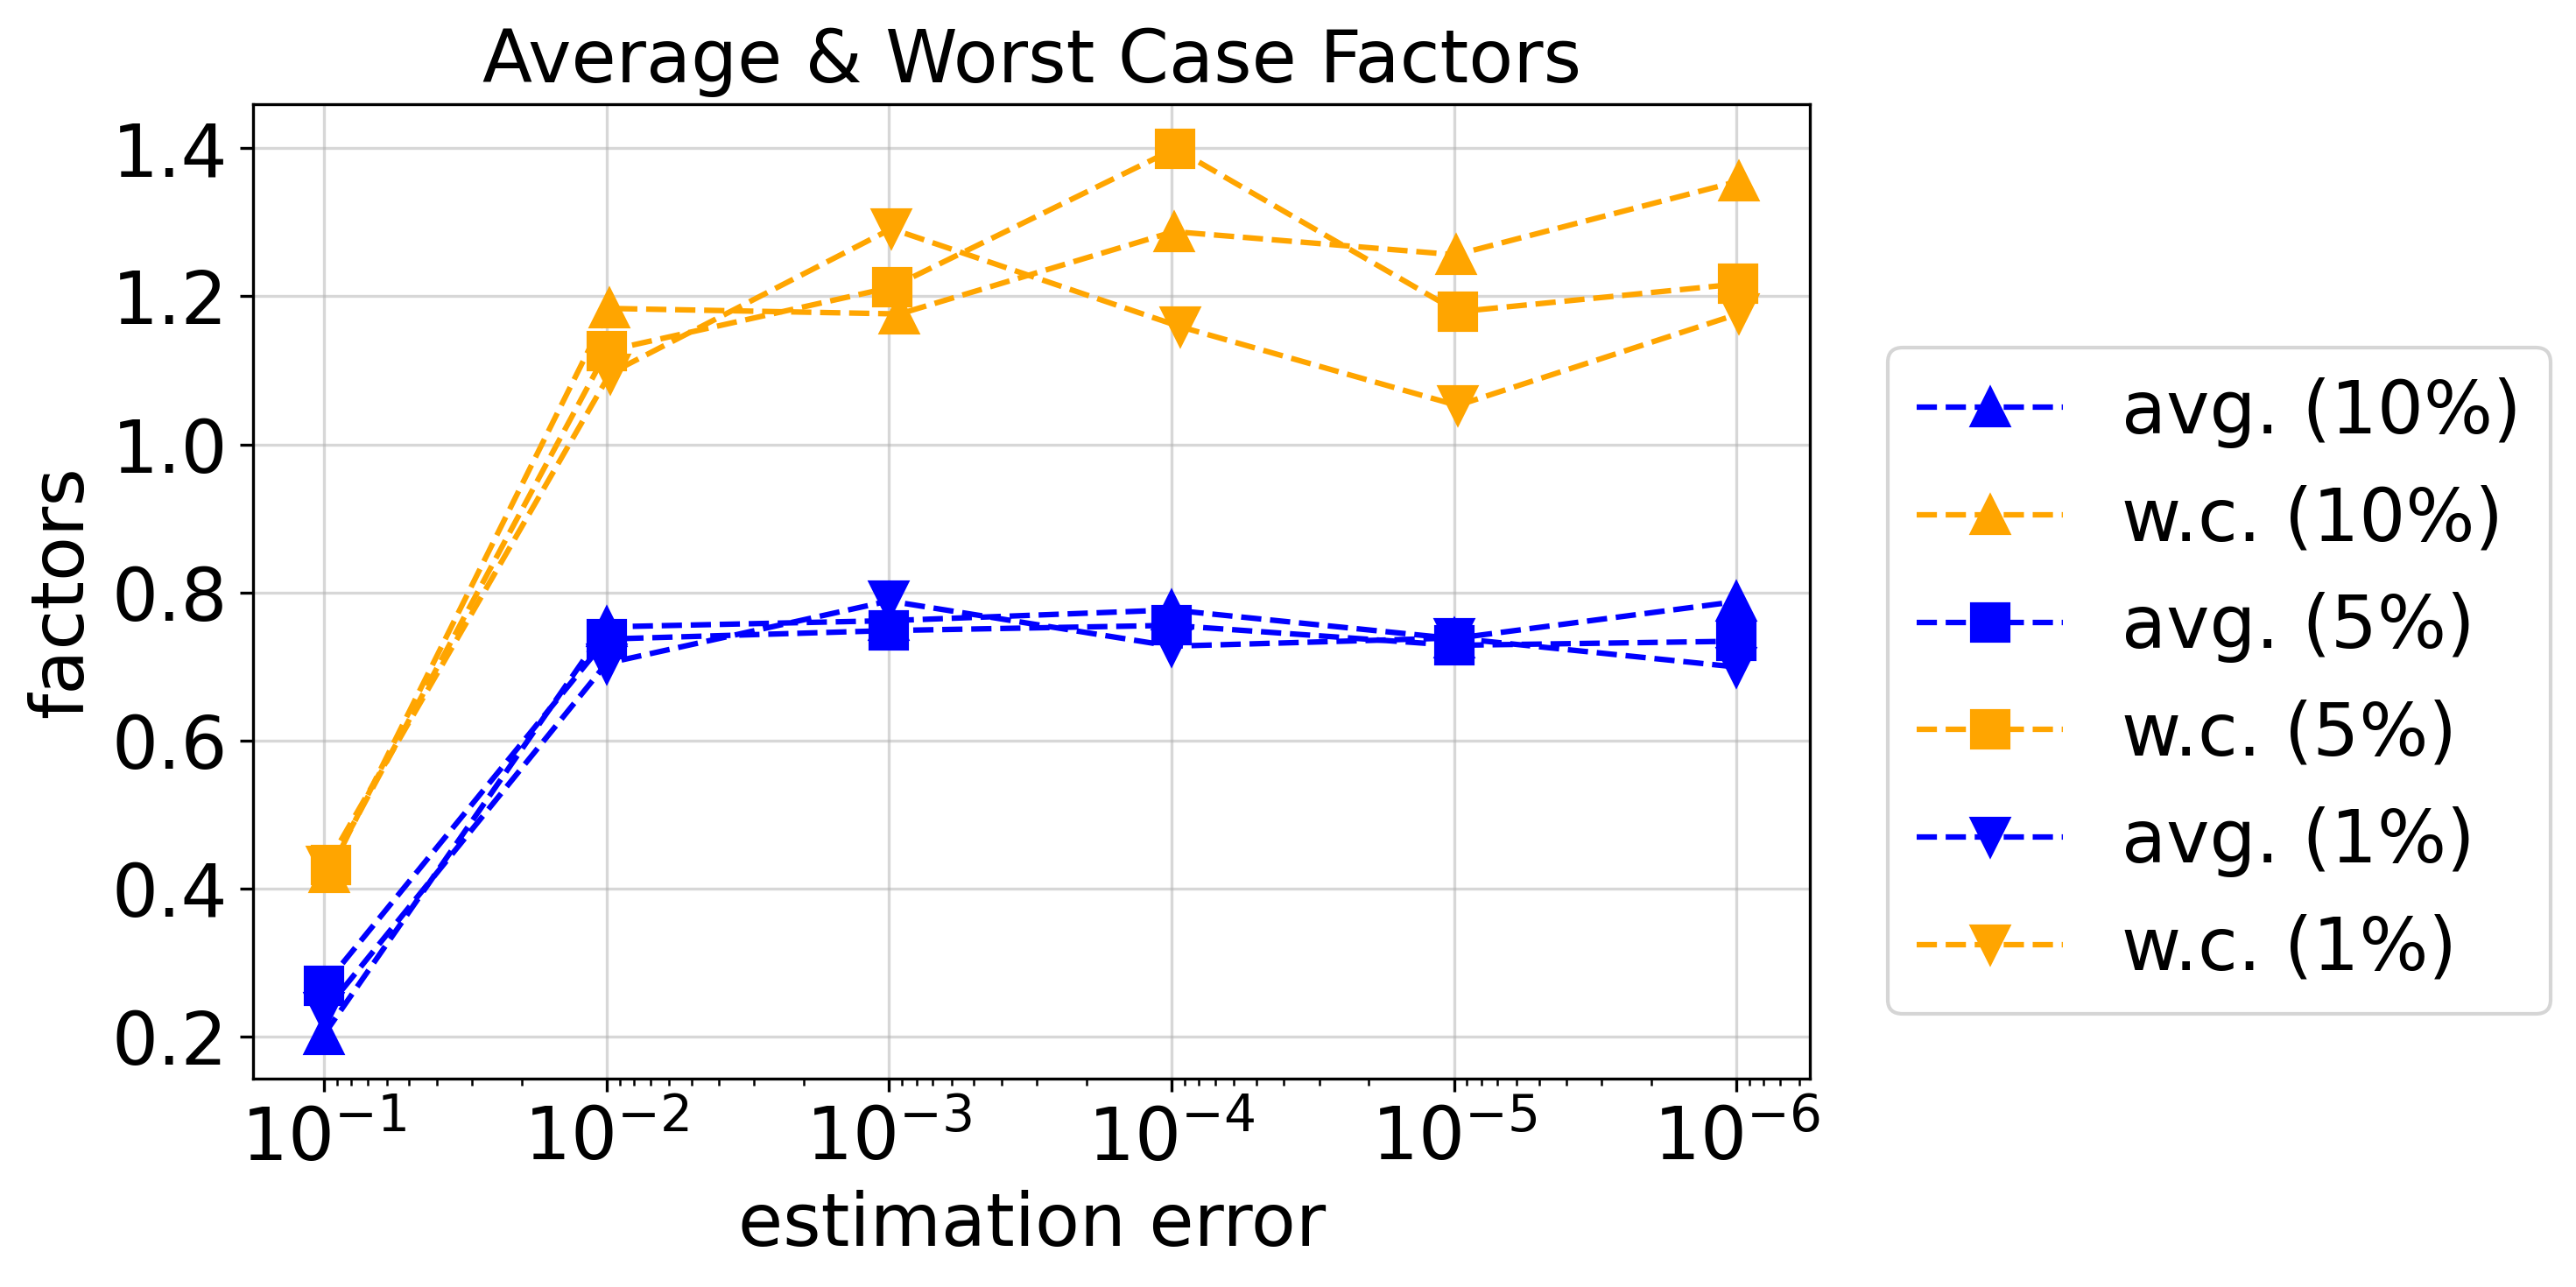

In [24]:
fontsize = 20
linewidth = 1.5
markersize = 10
plt.figure(figsize=(10, 5), dpi=300)
markers = { 0.1 : '^--',
    0.05 : 's--',
    0.01 : 'v--',
}
for alpha in alphas:
    plt.semilogx(epsilons,[np.mean(factors_cp[(alpha,x)]) for x in epsilons], markers[alpha], c='b', label='avg. (%d%%)'%int(100*alpha), 
                 linewidth=linewidth, markersize=markersize)
    plt.semilogx([np.array(iqae_cp[(x,alpha)]).T[1][np.argmax(factors_cp[(alpha,x)])] for x in epsilons],
                 [np.max(factors_cp[(alpha,x)]) for x in epsilons],  markers[alpha], c='orange', label='w.c. (%d%%)'%int(100*alpha), 
                 linewidth=linewidth, markersize=markersize)
plt.gca().invert_xaxis()
plt.title('Average & Worst Case Factors',fontsize=fontsize)
plt.legend(bbox_to_anchor=(1.05, 0.75), loc='upper left', borderaxespad=0., fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('estimation error',fontsize=fontsize)
plt.ylabel('factors', fontsize=fontsize)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('iqae_cp_factors.pdf')
plt.show()